In [1]:
%matplotlib inline

In [2]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import urllib2 as url
import re
import numpy as np
import pandas as pd

# Brain folding

The surface reconstruction is a list of vertices and a list of triangles constructed from these vertices. The topology of the reconstruction is that of a sphere. We first read the number of vertices, the number of triangles, and then the list of vertices and the list of triangles.

### Total surface area, $S$
The total surface area of the brain is approximated by the sum of the surface area of each triangle of its surface reconstruction:

\begin{equation}
S=\sum_{i=1}^{N_t}{A(T_i)},
\end{equation}

where $A(T_i)$ is the surface area of the $i$-th triangle.

### Total volume, $V$
The volume of the reconstruction, computed for example using the sum of the signed volume of each triangle in the reconstruction:

\begin{equation}
V=\frac 1 6 \sum_{i=1}^{N_t}{det(P(T_i))}
\end{equation}

where $det(P(T_i))/6$ is the signed volume of the tetrahedron formed by the vertices of the $i$-th triangle and the origin of the coordinates system.

### Absolute folding, $F$
We can obtain a first global index of folding from these two values, that we call the absolute folding index, $F$. We define absolute folding as the ratio between the total surface area of the reconstruction, $S$, and $S_{sphere}$, the surface of a sphere with the same volume of the reconstruction, $V$:

\begin{equation}
F=\frac S {S_\text{sphere}},
\end{equation}

because

\begin{equation}
S_\text{sphere}=(36 \pi)^{1/3} V^{2/3},
\end{equation}

then

\begin{equation}
F=\frac {S} {(36 \pi)^{1/3} V^{2/3}}.
\end{equation}

Several researchers have defined similar indices of global folding where the total surface area $S$ is divided by the surface of a smooth envelope of the reconstruction. In those cases, the index obtained will depend on the method used to compute that smooth envelope, a convex hull for example. But because different brains will have different smooth envelopes, the baseline for comparison will change each time. In our case, the surface of the sphere with the same volume of the reconstruction is the smallest possible surface for that volume, which provides an absolute measurement of the degree of folding. Figure \ref{fig:absoluteFolding} shows the value of $F$ for several geometric objects as well as neocortical reconstructions of different mammalian species.

In [7]:
# some basic measuremets, this takes some time

# import the data 

species = [ 
           'galago',
           'slow_loris', 
           'douroucouli', 
           'capuchin', 
           'mangabey', 
           'rhesus_macaque',  
           'ce_macaque', 
           'baboon',     
           'orangutan', 
           'gorilla', 
           'roberto',
          ]
nt_species = []
nv_species = []
S_species = []
V_species = []
F_species = []
X_species = []
Y_species = []
Z_species = []

# you can insert direct link to the mesh from the BrainCatalogue instead

for specie in species: 
    mesh_url="file:///Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/BrainCatalogueWorkflow/meshes_centered/%s/both.ply" % (specie)
    response=url.urlopen(mesh_url)
    text=response.read()
    text=text.split("\n")

    parser=re.compile("\d+")
    for line in text:
        if "element vertex" in line:
            nv=int(parser.findall(line)[0])
        if "element face" in line:
            nt=int(parser.findall(line)[0])
        if "end_header" in line:
            off=text.index(line)+1
            break
    nt_species.append(nt)
    nv_species.append(nv)

    p=np.array([])
    for i in range(off,off+nv):
        p=np.concatenate([p,np.fromstring(text[i],dtype=float,sep=" ")])
    p=p.reshape(nv,3)


    t=np.array([])
    for i in range(off+nv,off+nv+nt):
        tr=np.fromstring(text[i],dtype=int,sep=" ");
        t=np.concatenate([t,[tr[1],tr[2],tr[3]]])
    t=t.reshape(nt,3)
    
# Surface area
    def A(p0,p1,p2):
        #a,b,c    // side lengths
        #s        // semiperimeter
        a=np.linalg.norm(p0-p1);
        b=np.linalg.norm(p1-p2);
        c=np.linalg.norm(p2-p0);
        s=(a+b+c)/2.0;
        return np.sqrt(s*(s-a)*(s-b)*(s-c))

    S=0
    for i in range(0,nt):
        S+=A(p[t[i][0]],p[t[i][1]],p[t[i][2]])
    S_species.append(S)    

#Volume
    # Based on code by S. Melax from http://www.melax.com/volint/
    def volume(p0,p1,p2):
        return np.linalg.det([p0,p1,p2])/6.0

    V=0
    for i in range(0,nt):
        V+=volume(p[t[i][0]],p[t[i][1]],p[t[i][2]])
    V_species.append(V)
    
    

#absolute folding index
    def absFolding(s,v):
        return s/(v**(2/3.0)*(36.0*np.pi)**(1/3.0))
    #print absFolding(4*np.pi,(4/3.0)*np.pi) #test for a sphere

    F=absFolding(S,V)
    F_species.append(F)
    
    
    
    print "Specie",specie
#    print "Reading",nv,"vertices and",nt,"triangles." 
#    print "Surface area:",S,"Volume:",V
#    print "Absolute folding:",F
    
    #check the size of the brain in X, Y, Z axes
    
    Xmin = p[0, 0]
    Xmax = p[0, 0]

    for i in range(0, nv):
        if p[i, 0] < Xmin:
            Xmin = p[i, 0]
        if p[i, 0] > Xmax:
            Xmax = p[i, 0]

    Ymin = p[0, 1]
    Ymax = p[0, 1]
    for i in range(0, nv):
        if p[i, 1] < Ymin:
            Ymin = p[i, 1]
        if p[i, 1] > Ymax:
            Ymax = p[i, 1]

    Zmin = p[0, 2]
    Zmax = p[0, 2]
    for i in range(0, nv):
        if p[i, 1] < Zmin:
            Zmin = p[i, 2]
        if p[i, 1] > Zmax:
            Zmax = p[i, 2]
    X=Xmax-Xmin
    Y=Ymax-Ymin
    Z=Zmax-Zmin

    X_species.append(X)
    Y_species.append(Y)
    Z_species.append(Z)
    
#    print "X:", X, "Y:", Y, "Z:", Z





/Users/ghfc/anaconda2/envs/julia/lib/python2.7/site-packages/ipykernel/__main__.py:71: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ghfc/anaconda2/envs/julia/lib/python2.7/site-packages/ipykernel/__main__.py:81: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [8]:
V_species_cm = np.asarray(V_species)/1000 #convert to cm3
S_species_cm = np.asarray(S_species)/100 #convert to cm2

print V_species_cm, V_species

[    1.81766675     4.03740543    11.67019041    38.85435442    49.18347842
    27.15590946    58.03733162    89.7470672    185.12524888   275.28515419
  1142.10384958] [1817.6667539863877, 4037.4054265033969, 11670.190408677552, 38854.3544175305, 49183.478416936574, 27155.909464483717, 58037.331619323362, 89747.067203233077, 185125.24887854507, 275285.15419069293, 1142103.8495849166]


In [9]:
# save the data to .csv and .txt 

allinamatrix = np.matrix([V_species_cm, S_species_cm, F_species, nv_species, nt_species, X_species, Y_species, Z_species])
allinamatrix = allinamatrix.transpose()
names = ['Volume[cm3]', 'Surface area[cm2]', 'Absolute folding', 'N vertices', 'N triangles', 'X[mm]', 'Y[mm]', 'Z[mm]']
allinamatrix = pd.DataFrame(allinamatrix, index = species, columns=names)
print allinamatrix
allinamatrix.to_csv('species_data.txt', index=True, header=True, sep=' ')
allinamatrix.to_csv('species_data.csv', index=True, header=True, sep=',')


                Volume[cm3]  Surface area[cm2]  Absolute folding  N vertices  \
galago             1.817667          12.358498          1.715821        5002   
slow_loris         4.037405          20.493956          1.671373        6856   
douroucouli       11.670190          46.542918          1.870614        9968   
capuchin          38.854354         127.502019          2.298299       12560   
mangabey          49.183478         188.876828          2.909478       19939   
rhesus_macaque    27.155909         116.895296          2.675490       12489   
ce_macaque        58.037332         203.506226          2.807299       10997   
baboon            89.747067         259.184294          2.673690        7502   
orangutan        185.125249         410.111516          2.610803       12488   
gorilla          275.285154         542.467507          2.650744       15001   
roberto         1142.103850        2377.333215          4.499202       50002   

                N triangles       X[mm]

slope = 0.80304342014


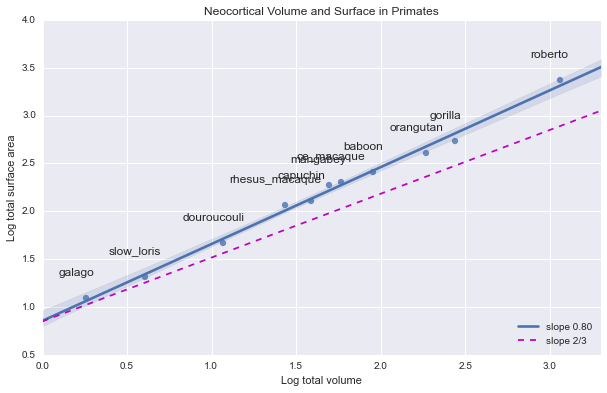

In [12]:
# plot data in allometric function

x = np.asarray(V_species)/1000 #convert to cm3
y = np.asarray(S_species)/100 #convert to cm2

## now for log10
for index, item in enumerate(y):
    y[index] = math.log10(item)
for index, item in enumerate(x):
    x[index] = math.log10(item)
    
    


fig = plt.figure()
fig.set_size_inches(10, 6)
ax = sns.regplot(x,y, scatter_kws={'s':40})
plt.title("Neocortical Volume and Surface in Primates")
plt.xlabel('Log total volume')
plt.ylabel('Log total surface area')
slope, intercept= np.polyfit(x,y,1)
print('slope = ' + str(slope))
plt.ylim([0.5,4])
plt.xlim([0.0,3.3])
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()



for i in [0,1,2,3,5,6,7,8,9]:
    for xy in zip(x, y):
        ax.annotate('%s' % (species[i]), xy=xy, xytext=(-10,20), textcoords='offset points', ha='center', va='bottom',
#            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.6),
#            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
#                            color='red')
        )
        i=i+1
    break

    

# 2/3 slope
x1 = np.arange(0, 4, step=0.1)
y1 = (2./3.)*x1 + 0.85
a, b= np.polyfit(x1,y1,1)
plt.plot(x1, a*x1 + b, 'm--')
plt.legend(['slope 0.80', 'slope 2/3'], loc=4)
#plt.savefig('allometry.png') #update with your path
plt.show()